In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [72]:
class MyNeuralNetwork:            
    def __init__(self, layers, learning_rate, momentum, activation, validation_percentage=0):
        self.L = len(layers)
        self.n = layers.copy()
        self.xi = [np.zeros(l) for l in layers]
        self.w = [np.random.randn(layers[i], layers[i-1]) for i in range(1, self.L)]
        self.theta = [np.zeros(l) for l in layers]
        self.delta = [np.zeros(l) for l in layers]
        self.d_w = [np.zeros_like(w) for w in self.w]
        self.d_theta = [np.zeros_like(t) for t in self.theta]
        self.d_w_prev = [np.zeros_like(w) for w in self.w]
        self.d_theta_prev = [np.zeros_like(t) for t in self.theta]
        self.learning_rate = learning_rate 
        self.momentum = momentum 
        self.activation = activation
        self.validation_percentage = validation_percentage
        self.loss_epochs = []

    def activation_function(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'linear':
            return x
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Invalid activation function")

    def activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation == 'linear':
            return 1
        elif self.activation == 'tanh':
            return 1 - x**2
        else:
            raise ValueError("Invalid activation function")

    def forward_pass(self, x):
        self.xi[0] = x
        for i in range(1, self.L):
            self.xi[i] = self.activation_function(np.dot(self.w[i-1], self.xi[i-1]) - self.theta[i])

    def backward_pass(self, y):
        self.delta[-1] = (self.xi[-1] - y) * self.activation_derivative(self.xi[-1])
        for i in range(self.L - 2, 0, -1):
            self.delta[i] = np.dot(self.w[i].T, self.delta[i+1]) * self.activation_derivative(self.xi[i])

    def update_weights(self):
        for i in range(1, self.L):
            self.d_w[i-1] = self.learning_rate * np.outer(self.delta[i], self.xi[i-1]) + self.momentum * self.d_w_prev[i-1]
            self.d_theta[i] = self.learning_rate * self.delta[i] + self.momentum * self.d_theta_prev[i]
            self.w[i-1] -= self.d_w[i-1]
            self.theta[i] -= self.d_theta[i]
            self.d_w_prev[i-1] = self.d_w[i-1]
            self.d_theta_prev[i] = self.d_theta[i]
            
    def mape(self, y_true, y_pred):
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    def fit(self, X, y, epochs, batch_size=32, learning_rate_decay=0.1):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.validation_percentage, random_state=42)

        for epoch in range(epochs):
            for _ in range(0, len(X_train), batch_size):
                batch_indices = np.random.choice(len(X_train), min(batch_size, len(X_train)), replace=False)
                if len(batch_indices) < 2:  # Skip batches with less than 2 samples
                    continue

                X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]

                for i in range(len(X_batch)):
                    x_sample, y_sample = X_batch[i], y_batch[i]
                    self.forward_pass(x_sample)
                    self.backward_pass(y_sample)
                    self.update_weights()

            # Calculate metrics with safeguards
            train_predictions = self.predict(X_train)
            val_predictions = self.predict(X_val)

            training_error = mean_squared_error(y_train, train_predictions)
            validation_error = mean_squared_error(y_val, val_predictions)

            training_r2 = r2_score(y_train, train_predictions) if len(y_train) > 1 else None
            validation_r2 = r2_score(y_val, val_predictions) if len(y_val) > 1 else None

            print(f"Epoch {epoch}/{epochs} - Training Error: {training_error}, Validation Error: {validation_error}, Training R2: {training_r2}, Validation R2: {validation_r2}")

            # Learning rate decay
            self.learning_rate *= (1.0 / (1.0 + learning_rate_decay * epoch))

        final_train_mape = self.mape(y_train, self.predict(X_train))
        final_val_mape = self.mape(y_val, self.predict(X_val))
        final_train_r2 = r2_score(y_train, self.predict(X_train))
        final_val_r2 = r2_score(y_val, self.predict(X_val))
        print(f"Final Training MAPE: {final_train_mape}, Final Validation MAPE: {final_val_mape}")
        print(f"Final Training R2: {final_train_r2}")
        print(f"Final Training MSE: {training_error}, Final Validation MSE: {validation_error}")
        return np.array(self.loss_epochs)
    
    
    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            self.forward_pass(X[i])
            predictions.append(self.xi[-1][0])
        return np.array(predictions)

    def get_loss_epochs(self):
        return np.array(self.loss_epochs)

In [73]:
# Define neural network parameters with two hidden layers
layers = [4, 9, 14, 1]  # Input layer: 13 features, Hidden layers: 10, 8, Output layer: 1 unit
learning_rate = 0.001
momentum = 0.9
activation = 'relu'
validation_percentage = 0.2
epochs = 100

In [74]:
# Create and train the neural network
nn = MyNeuralNetwork(layers, learning_rate, momentum, activation, validation_percentage)
loss_history = nn.fit(X, y, epochs)

Epoch 0/100 - Training Error: 1.2582862039476381, Validation Error: 0.8439444287553015, Training R2: -0.02511479268423078, Validation R2: None
Epoch 1/100 - Training Error: 1.2582862039476381, Validation Error: 0.8439444287553015, Training R2: -0.02511479268423078, Validation R2: None
Epoch 2/100 - Training Error: 1.2582862039476381, Validation Error: 0.8439444287553015, Training R2: -0.02511479268423078, Validation R2: None
Epoch 3/100 - Training Error: 1.2582862039476381, Validation Error: 0.8439444287553015, Training R2: -0.02511479268423078, Validation R2: None
Epoch 4/100 - Training Error: 1.2582862039476381, Validation Error: 0.8439444287553015, Training R2: -0.02511479268423078, Validation R2: None
Epoch 5/100 - Training Error: 1.2582862039476381, Validation Error: 0.8439444287553015, Training R2: -0.02511479268423078, Validation R2: None
Epoch 6/100 - Training Error: 1.2582862039476381, Validation Error: 0.8439444287553015, Training R2: -0.02511479268423078, Validation R2: None

C:\Users\pranj\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [89]:
# Extract features (X) and target variable (y)
X = synthetic_data.drop('z', axis=1).values
y = synthetic_data['z'].values

In [94]:
# Define neural network parameters with two hidden layers
layers = [9, 50, 100, 1]  # Input layer: 13 features, Hidden layers: 10, 8, Output layer: 1 unit
learning_rate = 0.001
momentum = 0.8
activation = 'sigmoid'
validation_percentage = 0.2
epochs = 100

In [95]:
# Create and train the neural network
nn = MyNeuralNetwork(layers, learning_rate, momentum, activation, validation_percentage)
loss_history = nn.fit(X, y, epochs)

Epoch 0/100 - Training Error: 0.7887362376928527, Validation Error: 0.7851215148098771, Training R2: 0.19638546504096477, Validation R2: 0.2596627862855869
Epoch 1/100 - Training Error: 0.637979161331848, Validation Error: 0.6238674370026795, Training R2: 0.3499863420160262, Validation R2: 0.4117187322913173
Epoch 2/100 - Training Error: 0.6053714304990234, Validation Error: 0.5861902776414014, Training R2: 0.38320916759069434, Validation R2: 0.44724673993858854
Epoch 3/100 - Training Error: 0.585825573032292, Validation Error: 0.5669293510880027, Training R2: 0.4031237276272014, Validation R2: 0.4654089994476204
Epoch 4/100 - Training Error: 0.579723560961554, Validation Error: 0.559943686363724, Training R2: 0.4093408447801856, Validation R2: 0.47199619322636677
Epoch 5/100 - Training Error: 0.5753050935574613, Validation Error: 0.5549890996233647, Training R2: 0.4138426597830793, Validation R2: 0.4766681642184649
Epoch 6/100 - Training Error: 0.5730678313503111, Validation Error: 0.

In [96]:
# Plot the evolution of the training and validation errors
import matplotlib.pyplot as plt

plt.plot(loss_history[:, 0], label='Training Error')
plt.plot(loss_history[:, 1], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

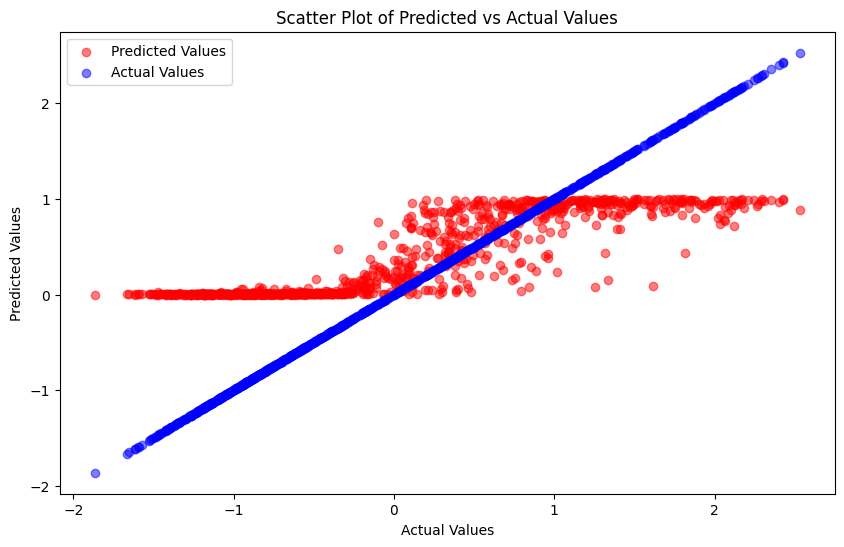

In [97]:
# Scatter plot with diagonal line and separate colors for predicted and actual values
plt.figure(figsize=(10, 6))
predictions = nn.predict(X)
plt.scatter(y, predictions, color='red', label='Predicted Values', alpha=0.5)
plt.scatter(y, y, color='blue', label='Actual Values', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.legend()
plt.show()

Epoch 1/50 - Train Loss: 537.1733, Val Loss: 606.6377
Epoch 2/50 - Train Loss: 25954637.1919, Val Loss: 28464227.3141
Epoch 3/50 - Train Loss: 5175665225.0859, Val Loss: 5565054664.5122
Epoch 4/50 - Train Loss: 154880943346.8714, Val Loss: 256332179225.4294
Epoch 5/50 - Train Loss: 2057816717608.0825, Val Loss: 2341825416254.4351
Epoch 6/50 - Train Loss: 27247599549250.0898, Val Loss: 33166985645118.3008
Epoch 7/50 - Train Loss: 133188962550255.9531, Val Loss: 135974552403961.5312
Epoch 8/50 - Train Loss: 339311140268190.8750, Val Loss: 497159177429776.9375
Epoch 9/50 - Train Loss: 635281158203575.2500, Val Loss: 904752066872363.6250
Epoch 10/50 - Train Loss: 797940039752930.2500, Val Loss: 1315285785979680.0000
Epoch 11/50 - Train Loss: 1182757848666862.2500, Val Loss: 1129423945498102.2500
Epoch 12/50 - Train Loss: 1231721043567748.0000, Val Loss: 1740265213546619.5000
Epoch 13/50 - Train Loss: 1370015265684871.2500, Val Loss: 1445290829414649.5000
Epoch 14/50 - Train Loss: 134850357

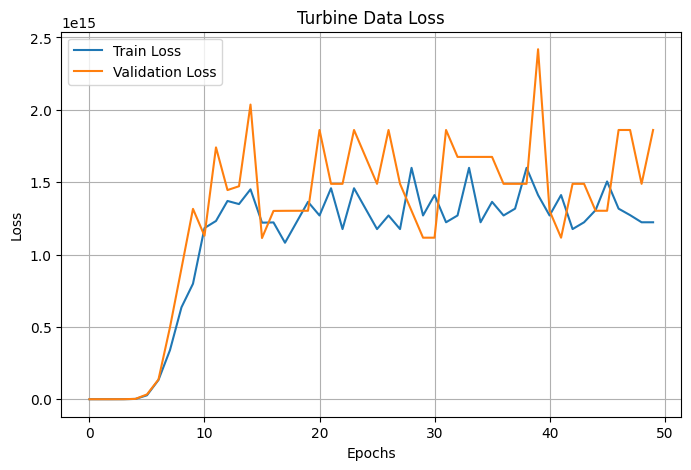

Epoch 1/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 2/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 3/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 4/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 5/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 6/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 7/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 8/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 9/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 10/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 11/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 12/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 13/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 14/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 15/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 16/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 17/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 18/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 19/50 - Train Loss: 0.9822, Val Loss: 1.0713
Epoch 20/50 - Train Loss: 0.9822, Val Lo

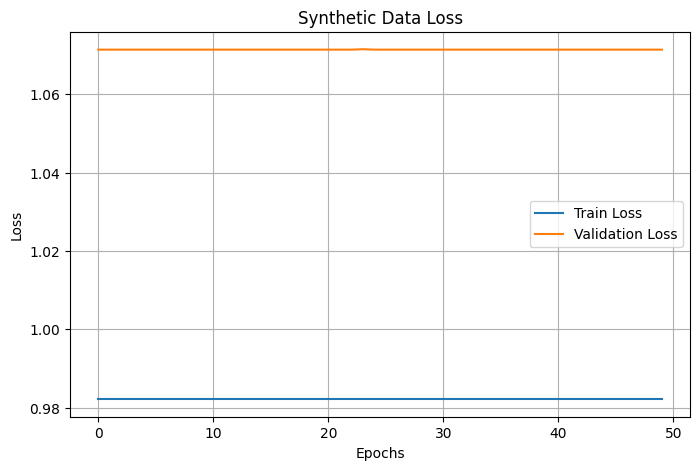

Epoch 1/50 - Train Loss: 0.4577, Val Loss: 0.5107
Epoch 2/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 3/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 4/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 5/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 6/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 7/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 8/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 9/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 10/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 11/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 12/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 13/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 14/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 15/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 16/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 17/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 18/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 19/50 - Train Loss: 0.4863, Val Loss: 0.5550
Epoch 20/50 - Train Loss: 0.4863, Val Lo

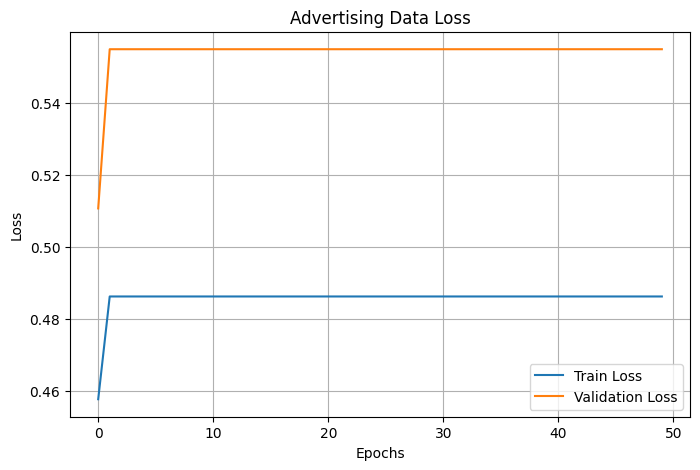

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ================================
# 1. Utility Functions
# ================================

def load_dataset(file_path, target_column):
    """
    Load a dataset and split into features (X) and target (y).
    """
    data = pd.read_csv(file_path, sep=',', header=0)
    X = data.drop(target_column, axis=1).values
    y = data[target_column].values
    return X, y

def plot_loss(loss, title):
    """
    Plot training and validation loss.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(loss[:, 0], label='Train Loss')
    plt.plot(loss[:, 1], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# ================================
# 2. Neural Network Class
# ================================

class OptimizedNeuralNetwork:
    def __init__(self, layers, learning_rate, momentum, activation, validation_percentage=0.2, dropout_rate=0.0):
        self.L = len(layers)
        self.layers = layers
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.activation = activation
        self.validation_percentage = validation_percentage
        self.dropout_rate = dropout_rate
        
        # Initialize weights and biases
        self.w = [np.random.randn(layers[i], layers[i-1]) * np.sqrt(2 / layers[i-1]) for i in range(1, self.L)]  # He Initialization
        self.theta = [np.zeros(l) for l in layers]
        self.d_w_prev = [np.zeros_like(w) for w in self.w]
        self.d_theta_prev = [np.zeros_like(t) for t in self.theta]
        self.xi = [np.zeros(l) for l in layers]
        self.delta = [np.zeros(l) for l in layers]
        self.loss_epochs = []

    def activation_function(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'linear':
            return x
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Invalid activation function")

    def activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation == 'linear':
            return 1
        elif self.activation == 'tanh':
            return 1 - x**2
        else:
            raise ValueError("Invalid activation function")

    def forward_pass(self, x):
        self.xi[0] = x
        for i in range(1, self.L):
            z = np.dot(self.w[i-1], self.xi[i-1]) - self.theta[i]
            self.xi[i] = self.activation_function(z)
            if self.dropout_rate > 0.0 and i < self.L - 1:  # Apply dropout to hidden layers
                dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, size=self.xi[i].shape)
                self.xi[i] *= dropout_mask

    def backward_pass(self, y):
        self.delta[-1] = (self.xi[-1] - y) * self.activation_derivative(self.xi[-1])
        for i in range(self.L - 2, 0, -1):
            self.delta[i] = np.dot(self.w[i].T, self.delta[i+1]) * self.activation_derivative(self.xi[i])

    def update_weights(self):
        for i in range(1, self.L):
            d_w = self.learning_rate * np.outer(self.delta[i], self.xi[i-1]) + self.momentum * self.d_w_prev[i-1]
            d_theta = self.learning_rate * self.delta[i] + self.momentum * self.d_theta_prev[i]
            self.w[i-1] -= d_w
            self.theta[i] -= d_theta
            self.d_w_prev[i-1] = d_w
            self.d_theta_prev[i] = d_theta

    def fit(self, X, y, epochs, batch_size=32, learning_rate_decay=0.1):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.validation_percentage, random_state=42)
        for epoch in range(epochs):
            for _ in range(0, len(X_train), batch_size):
                batch_indices = np.random.choice(len(X_train), min(batch_size, len(X_train)), replace=False)
                for i in batch_indices:
                    self.forward_pass(X_train[i])
                    self.backward_pass(y_train[i])
                    self.update_weights()
            # Log training and validation loss
            train_loss = mean_squared_error(y_train, self.predict(X_train))
            val_loss = mean_squared_error(y_val, self.predict(X_val))
            self.loss_epochs.append([train_loss, val_loss])
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            self.learning_rate *= (1.0 / (1.0 + learning_rate_decay * epoch))
        return np.array(self.loss_epochs)

    def predict(self, X):
        predictions = []
        for x in X:
            self.forward_pass(x)
            predictions.append(self.xi[-1][0])
        return np.array(predictions)

# ================================
# 3. Main Training and Evaluation
# ================================

# Dataset details
datasets = {
    "Turbine Data": ("Preprocessed/Preprocessed_A1_turbine.csv", "power"),
    "Synthetic Data": ("Preprocessed/Preprocessed_A1_synthetic.csv", "z"),
    "Advertising Data": ("Preprocessed/preprocessed_Adversting_data.csv", "Clicked on Ad"),
}

# Common parameters
learning_rate = 0.01
momentum = 0.9
activation = 'relu'
epochs = 50
dropout_rate = 0.2

# Train and evaluate models
for name, (file_path, target_column) in datasets.items():
    X, y = load_dataset(file_path, target_column)
    layers = [X.shape[1], 10, 10, 1]
    model = OptimizedNeuralNetwork(layers, learning_rate, momentum, activation, dropout_rate=dropout_rate)
    loss = model.fit(X, y, epochs)
    plot_loss(loss, f"{name} Loss")
